[0]	validation_0-rmse:303299.77606	validation_1-rmse:321453.86519
[100]	validation_0-rmse:152319.21745	validation_1-rmse:182845.58237
[200]	validation_0-rmse:102902.19483	validation_1-rmse:149870.57562
[300]	validation_0-rmse:83029.87505	validation_1-rmse:141374.28971
[400]	validation_0-rmse:69651.90424	validation_1-rmse:138794.36455
[500]	validation_0-rmse:63772.77549	validation_1-rmse:137051.09219
[600]	validation_0-rmse:59346.62136	validation_1-rmse:135659.19303
[700]	validation_0-rmse:55093.95046	validation_1-rmse:134172.58400
[800]	validation_0-rmse:51474.76783	validation_1-rmse:133198.67859
[900]	validation_0-rmse:47994.70359	validation_1-rmse:132154.14022
[999]	validation_0-rmse:44774.08949	validation_1-rmse:131262.51089
R^2: 0.4225
MAE: 89870.71 MWh/día


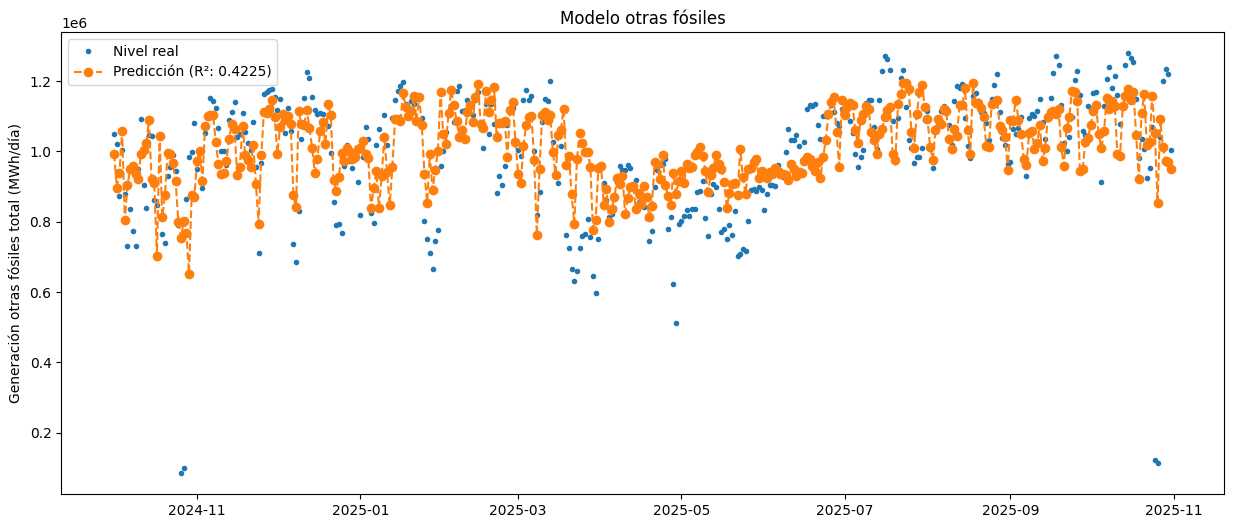

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

DATA_PATH = '../data/2_processed/dataset_maestro_5min.parquet'
df_5min = pd.read_parquet(DATA_PATH)
df_5min = df_5min.sort_index()

df_5min['sol_total'] = df_5min['solFot'] + df_5min['solTer']

df_5min['otras_fosiles_total'] = df_5min['cogenResto'] + \
                                 df_5min['die'] + \
                                 df_5min['gas'] + \
                                 df_5min['vap'] + \
                                 df_5min['genAux'] + \
                                 df_5min['termRenov']


agg_dict = {
    'otras_fosiles_total': 'sum',
    
    'temp_max_nacional_ponderada': 'first',
    'temp_min_nacional_ponderada': 'first',
    'viento_nacional_ponderado': 'first',
    'precipitacion_nacional_ponderada': 'first',

    'dia_año_sin': 'first',
    'dia_año_cos': 'first',
    'dia_semana_sin': 'first',
    'dia_semana_cos': 'first',
}

df_1d = df_5min.resample('D').agg(agg_dict)

df_1d['otras_fosiles_lag_7d'] = df_1d['otras_fosiles_total'].shift(7)
df_1d['otras_fosiles_lag_14d'] = df_1d['otras_fosiles_total'].shift(14)
df_1d['otras_fosiles_mean_28d'] = df_1d['otras_fosiles_total'].shift(7).rolling(window=28).mean()
df_1d['otras_fosiles_std_28d'] = df_1d['otras_fosiles_total'].shift(7).rolling(window=28).std()

df_1d = df_1d.dropna() 

TARGET_NIVEL = 'otras_fosiles_total'
FEATURES_NIVEL = [
    'dia_año_sin',
    'dia_año_cos',
    'dia_semana_sin',
    'dia_semana_cos',

    'temp_max_nacional_ponderada',
    'temp_min_nacional_ponderada',
    'viento_nacional_ponderado',
    'precipitacion_nacional_ponderada',

    'otras_fosiles_lag_7d',
    'otras_fosiles_lag_14d',
    'otras_fosiles_mean_28d',
    'otras_fosiles_std_28d'
]

X = df_1d[FEATURES_NIVEL]
y = df_1d[TARGET_NIVEL]

TEST_START_DATE_DIARIO = '2024-10-01'
X_train = X.loc[X.index < TEST_START_DATE_DIARIO]
y_train = y.loc[y.index < TEST_START_DATE_DIARIO]

X_test = X.loc[X.index >= TEST_START_DATE_DIARIO]
y_test = y.loc[y.index >= TEST_START_DATE_DIARIO]

model_nivel_otras = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model_nivel_otras.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_test, y_test)],
                      verbose=100)

MODEL_PATH = '../models/modelo_otras.json'
model_nivel_otras.save_model(MODEL_PATH)

preds_nivel = model_nivel_otras.predict(X_test)
r2_nivel = r2_score(y_test, preds_nivel)
mae = mean_absolute_error(y_test, preds_nivel)

print(f"R^2: {r2_nivel:.4f}")
print(f"MAE: {mae:.2f} MWh/día")

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Nivel real', marker='.', linestyle='None')
plt.plot(y_test.index, preds_nivel, label=f'Predicción (R²: {r2_nivel:.4f})', 
         linestyle='--', marker='o')
plt.title('Modelo otras fósiles')
plt.ylabel('Generación otras fósiles total (MWh/día)')
plt.legend()
plt.show()